In [7]:
class Config():
  def __init__(
    self,
    num_classes,
    num_epochs,
    batch_size,
    learning_rate,
    early_stopping_patience,
    early_stopping_min_delta,
    use_saved_models,
    train_size,
    test_size,
    val_size,
    checkpoint_path,
  ):
    self.num_classes = num_classes
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_min_delta = early_stopping_min_delta

    self.use_saved_models = use_saved_models
    
    self.train_size = train_size
    self.test_size = test_size
    self.val_size = val_size

    self.checkpoint_path = checkpoint_path

cfg = Config(
    num_classes=5,
    num_epochs=100, # Due to dropout
    batch_size = 32,
    learning_rate = 1e-3,
    early_stopping_patience = 10, # Due to dropout
    early_stopping_min_delta = 0.01,
    use_saved_models = False,
    train_size = 0.9,
    test_size = 0.05,
    val_size = 0.05,
    checkpoint_path = '2_bor_tabular_postreleased/',
)

# Обработка данных

## Очистка

In [8]:
import pandas as pd
import numpy as np
from ast import literal_eval
from dateutil.parser import parse

df = pd.read_csv('./movie_dataset.csv', index_col=0)

to_drop = [
    'id', 
    'tagline', 
    'overview', 
    'vote_count', 
    'original_title', 
    'title', 
    'spoken_languages',
    'poster',
    'original_language',
]
df = df.drop(columns=to_drop)

df['budget'] = df['budget'].replace({0: np.nan})
df['revenue'] = df['revenue'].replace({0: np.nan})
df['runtime'] = df['runtime'].replace({0: np.nan})

df.dropna(inplace=True)
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

df['production_company'] = df.apply(lambda x: x['production_companies'][0], axis=1)
df['production_country'] = df.apply(lambda x: x['production_countries'][0], axis=1)
df = df.drop(columns=['production_companies', 'production_countries'], axis=1)

to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

df = df[df['actors'].map(len) == 3]
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

df = df.drop(columns=['imdb_id'], axis=1)

df = df.reset_index(drop=True)

## Формирование целевой переменной

In [9]:
def get_class(row):  
  R = row['revenue']
  if R <= 5000000:
    return 0
  elif 5000000 < R <= 20000000:
    return 1
  elif 20000000 < R <= 60000000:
    return 2
  elif 60000000 < R <= 145000000:
    return 3
  elif 145000000 < R:
    return 4
  return np.nan

df['target'] = df.apply(get_class, axis=1)
df = df.drop(columns=['revenue'], axis=1)

## Извлечение и преобразование признаков

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        # Жанры
        self.genres_mlb = MultiLabelBinarizer().fit(X['genres'].values)
        # Продюсерская компания
        self.production_company_encoder = LabelEncoder().fit(X['production_company'].values)
        # Страна производства
        self.production_country_encoder = LabelEncoder().fit(X['production_country'].values)
        # Дистрибьютор
        self.domestic_distributor_encoder = LabelEncoder().fit(X['domestic_distributor'].values)
        # Режиссер
        self.director_encoder = LabelEncoder().fit(X['director'].values)
        # Актеры
        unique_actors = pd.concat([df['actor_1'], df['actor_2'], df['actor_3']]).unique()
        self.actor_encoder = LabelEncoder().fit(unique_actors)
        # Месяц выхода
        self.release_month_encoder = OneHotEncoder(sparse_output=False).fit(X['release_month'].values.reshape(-1, 1))
        # Возрастной рейтинг
        self.mpaa_encoder = OneHotEncoder(sparse_output=False).fit(X['mpaa'].values.reshape(-1, 1))
        # Бюджет
        self.budget_scaler = StandardScaler().fit(X['budget'].values.reshape(-1, 1))
        # Длительность
        self.runtime_scaler = StandardScaler().fit(X['runtime'].values.reshape(-1, 1))
        # Средняя оценка
        self.vote_average_scaler = StandardScaler().fit(X['vote_average'].values.reshape(-1, 1))
        # Сборы в первый уикенд
        self.domestic_opening_scaler = StandardScaler().fit(X['domestic_opening'].values.reshape(-1, 1))

        self.columns_order = [
            'actor_1', 'actor_2', 'actor_3', 'director', 'production_company', 'production_country', 'domestic_distributor', 
            'runtime', 'budget', 'vote_average', 'domestic_opening',
            'genre_action', 'genre_adventure', 'genre_animation',
            'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
            'genre_family', 'genre_fantasy', 'genre_foreign', 'genre_history',
            'genre_horror', 'genre_music', 'genre_mystery', 'genre_romance',
            'genre_science_fiction', 'genre_thriller', 'genre_war', 'genre_western',
            'release_month_1', 'release_month_2', 'release_month_3',
            'release_month_4', 'release_month_5', 'release_month_6',
            'release_month_7', 'release_month_8', 'release_month_9',
            'release_month_10', 'release_month_11', 'release_month_12', 
            'mpaa_G', 'mpaa_NC-17', 'mpaa_PG', 'mpaa_PG-13', 'mpaa_R'
        ]

        return self

    def transform(self, X):
        # Жанры
        classes = [f'genre_{x.replace(" ", "_").lower()}' for x in self.genres_mlb.classes_]
        transformed_genres = self.genres_mlb.transform(X['genres'].values)
        X = X.join(pd.DataFrame(transformed_genres.astype(bool), X.index, classes))
        X = X.drop(columns=['genres'], axis=1)
        # Продюсерская компания
        X['production_company'] = self.production_company_encoder.transform(X['production_company'].values)
        # Страна производства
        X['production_country'] = self.production_country_encoder.transform(X['production_country'].values)
        # Дистрибьютор
        X['domestic_distributor'] = self.domestic_distributor_encoder.transform(X['domestic_distributor'].values)
        # Режиссер
        X['director'] = self.director_encoder.transform(X['director'].values)
        # Актеры
        for i in range(1, 4):
            X[f'actor_{i}'] = self.actor_encoder.transform(X[f'actor_{i}'].values)
        # Месяц выхода
        classes = [f'release_month_{x}' for x in self.release_month_encoder.categories_[0]]
        transfored_release_month = self.release_month_encoder.transform(X['release_month'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_release_month.astype(bool), X.index, classes))
        X = X.drop(columns=['release_month'], axis=1)
        # Возрастной рейтинг
        classes = [('mpaa_' + x.upper()) for x in self.mpaa_encoder.categories_[0]]
        transfored_mpaa = self.mpaa_encoder.transform(X['mpaa'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_mpaa.astype(bool), X.index, classes))
        X = X.drop(columns=['mpaa'], axis=1)
        # Бюджет
        X['budget'] = self.budget_scaler.transform(X['budget'].values.reshape(-1, 1))
        # Длительность
        X['runtime'] = self.runtime_scaler.transform(X['runtime'].values.reshape(-1, 1))
        # Средняя оценка
        X['vote_average'] = self.vote_average_scaler.transform(X['vote_average'].values.reshape(-1, 1))
        # Сборы в первый уикенд
        X['domestic_opening'] = self.domestic_opening_scaler.transform(X['domestic_opening'].values.reshape(-1, 1))

        X = X[self.columns_order]

        return X

preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', PreprocessingTransformer()),
]) 

X = df.drop(columns=['target'], axis=1)
y = df['target'].to_numpy()

# Fit and evaluate the model
X = preprocess_pipeline.fit_transform(X, y)

### Сохранение преобразования признаков

In [11]:
import dill

with open(f'{cfg.checkpoint_path}pipeline.pkl', 'wb') as f:
    dill.dump(preprocess_pipeline, f, protocol=5)

# Построение и обучение модели

Опишем фукнцию, которая будет оценивать получившуюся модель

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

results = {}

# Функция для оценки полученной модели
def inspect_model(model, test_generator, y, model_name, history=None):
  predictions = model.predict(test_generator)
  # real_classes = y.argmax(axis=1)
  real_classes = y
  predicted_classes = predictions.argmax(axis=1)

  # Exact and 1-class-away accuracy
  real_classes = real_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  predicted_classes = predicted_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  diffs = abs(real_classes - predicted_classes)

  exact_match = len(diffs[diffs <= 0]) / len(diffs)
  one_class_away = len(diffs[diffs <= 1]) / len(diffs)
  print('Exact match accuracy:', exact_match)
  print('One class away accuracy:', one_class_away)

  # Precision and recall
  precision = precision_score(real_classes, predicted_classes, average=None)
  recall = recall_score(real_classes, predicted_classes, average=None)
  f1 = f1_score(real_classes, predicted_classes, average=None)
  print("Precision per class:", precision)
  print("Recall per class:", recall)
  print("F1 score per class", f1)

  # Macro and Micro averaged Precision and Recall
  macro_precision = precision_score(real_classes, predicted_classes, average='macro')
  macro_recall = recall_score(real_classes, predicted_classes, average='macro')
  micro_precision = precision_score(real_classes, predicted_classes, average='micro')
  micro_recall = recall_score(real_classes, predicted_classes, average='micro')
  macro_f1 = f1_score(real_classes, predicted_classes, average='macro')
  micro_f1 = f1_score(real_classes, predicted_classes, average='micro')

  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1:", macro_f1)
  print("Micro Precision:", micro_precision)
  print("Micro Recall:", micro_recall)
  print("Micro F1:", micro_f1)
  
  # Confusion matrix
  m = confusion_matrix(real_classes, predicted_classes)
  ConfusionMatrixDisplay(m).plot()

  if (history != None):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss Function Over Epochs')
    ax.set_ylabel('Sparse Categorical Crossentropy value')
    ax.set_xlabel('No. epoch')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Accuracy Over Epochs')
    ax.set_ylabel('Accuracy value')
    ax.set_xlabel('No. epoch')
    plt.show()

  results[model_name] = {
      'exact_match': exact_match,
      'one_class_away': one_class_away,
  }

## Архитектура модели

In [13]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class SliceLayer(keras.layers.Layer):
    def __init__(self, start_index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start_index = start_index

    def call(self, inputs):
        # Your custom slicing logic goes here
        return inputs[:, self.start_index:]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({
            "start_index": self.start_index,
        })
        return config
    
@keras.saving.register_keras_serializable()
class IndexAndExpandLayer(keras.layers.Layer):
    def __init__(self, index):
        super().__init__()
        self.index = index

    def call(self, inputs):
        return tf.expand_dims(inputs[:,self.index],-1)

    def get_config(self):
        return {
            "index": self.index,
        }


2025-04-26 17:25:38.608021: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 17:25:38.611474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 17:25:38.621183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745677538.637782  864111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745677538.642735  864111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 17:25:38.660096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [14]:
import keras
from keras import layers
from keras.models import Model
import tensorflow as tf
import math

def build_model(
    original_input_shape,
    n_unique_actors,
    n_unique_directors,
    n_unique_production_companies,
    n_unique_production_countries, 
    n_unique_domestic_distributor,
    n_classes,
):
    def out_dim(n):
        return math.ceil(math.pow(n, 0.25))
        # return 20
    
    def build_embedding_cfg(name, input_dim, output_dim):
        return {
            'name': name,
            'input_dim': input_dim,
            'output_dim': output_dim,
        }
        
    input = layers.Input(shape=(original_input_shape,))
    
    embedding_cfg = [
        build_embedding_cfg('actor_1', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('actor_2', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('actor_3', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('director', n_unique_directors, out_dim(n_unique_directors)),
        build_embedding_cfg('production_company', n_unique_production_companies, out_dim(n_unique_production_companies)),
        build_embedding_cfg('production_country', n_unique_production_countries, out_dim(n_unique_production_countries)),
        build_embedding_cfg('domestic_distributor', n_unique_domestic_distributor, out_dim(n_unique_domestic_distributor)),
    ]

    embedding_outputs = []
    for i, cfg in enumerate(embedding_cfg):
        embedded_lambda = IndexAndExpandLayer(i)(input)
        embedding = layers.Embedding(
            input_dim=cfg['input_dim'],
            output_dim=cfg['output_dim'],
            name=cfg['name'],
        )(embedded_lambda)
        output = layers.Flatten()(embedding)

        embedding_outputs.append(output)

    other_lambda = SliceLayer(len(embedding_cfg))(input)

    merged = layers.concatenate([
        *embedding_outputs,
        other_lambda
    ])
    
    hidden = layers.Dense(64, activation='relu')(merged)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(256, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(64, activation='relu', name='output')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    output = layers.Dense(n_classes, activation='softmax')(hidden)

    inputs = input
    model = Model(inputs=inputs, outputs=output)

    return model

In [15]:
from keras.utils import plot_model

m = build_model(
    original_input_shape=X.shape[1],
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
)
plot_model(m, show_shapes=True, show_layer_activations=True, show_layer_names=True)

2025-04-26 17:25:40.035026: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
import tensorflow as tf

# Define the custom metric
@keras.saving.register_keras_serializable()
class OneClassAwayAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='one_class_away_accuracy', **kwargs):
        super(OneClassAwayAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.squeeze(y_true)

        # Determine correct predictions within one class
        correct = tf.cast(
            tf.math.logical_or(
                tf.equal(y_true, y_pred),
                tf.logical_or(
                    tf.equal(y_true, y_pred + 1),
                    tf.equal(y_true, y_pred - 1)
                )
            ),
            tf.float32
        )

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            correct = tf.multiply(correct, sample_weight)

        self.total.assign_add(tf.reduce_sum(correct))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)
    
    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)

print('Train size:', cfg.train_size)
print('Test size:', (1-cfg.train_size) * cfg.test_size/(cfg.test_size + cfg.val_size))
print('Val size:', (1-cfg.train_size) * cfg.val_size/(cfg.test_size + cfg.val_size))

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Val size:', X_val.shape)

Train size: 0.9
Test size: 0.04999999999999999
Val size: 0.04999999999999999
Train size: (3790, 47)
Test size: (211, 47)
Val size: (211, 47)


Определяем веса классов для сбаланированного разбиения (относительного целевого класса) на тренировочные и тестовые данные

In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {i: x for i, x in enumerate(class_weights)}

## Поиск оптимальных парметров обучения с помощью HalvingGridSearchCV

In [19]:
from keras.callbacks import EarlyStopping
from sklearn.experimental import enable_halving_search_cv
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

def halving_grid_search():
    def create_model():
        return build_model(
            original_input_shape=X.shape[1],
            n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
            n_unique_directors=X['director'].nunique(),
            n_unique_production_companies=X['production_company'].nunique(),
            n_unique_production_countries=X['production_country'].nunique(),
            n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
            n_classes=cfg.num_classes,
        )

    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience)

    model = KerasClassifier(
        model=create_model,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        epochs=cfg.num_epochs,
        class_weight=class_weights,
        callbacks=[
            early_stopping,
        ],
        validation_split=0.1,
    )

    params = {
        'optimizer': ['adam', 'adamw', 'adadelta', 'adagrad'],
        'batch_size': [16, 32, 64],
        "optimizer__learning_rate": [1e-2, 1e-3, 1e-4],
    }
    grid = HalvingGridSearchCV(
        estimator=model, 
        param_grid=params,
        scoring='accuracy',
        factor=3,
        cv=5,
        n_jobs=10,
    )

    grid_result = grid.fit(X_train, y_train)

    return grid_result
    

In [ ]:
import dill

halving_grid_search_result = halving_grid_search() # 10 min

with open(f'{cfg.checkpoint_path}halving_grid.pkl', 'wb') as f:
    dill.dump(halving_grid_search_result, f, protocol=5)

In [25]:
import dill

with open(f'{cfg.checkpoint_path}halving_grid.pkl', 'rb') as f:
    halving_grid_search_result = dill.load(f)

In [26]:
print("Best: %f using %s" % (halving_grid_search_result.best_score_, halving_grid_search_result.best_params_))

Best: 0.506085 using {'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}


In [27]:
results = pd.DataFrame(halving_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

,params,mean_test_score,std_test_score,rank_test_score
53,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.506085,0.008556,1
51,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.496032,0.029483,2
39,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.466667,0.081927,3
27,"{'batch_size': 64, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.01}",0.442857,0.128968,4
15,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.01}",0.442857,0.048445,4
0,"{'batch_size': 16, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01}",0.442857,0.083299,4
24,"{'batch_size': 64, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01}",0.407143,0.130931,7
44,"{'batch_size': 64, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01}",0.407143,0.080882,7
12,"{'batch_size': 32, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01}",0.378571,0.147427,9
50,"{'batch_size': 64, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01}",0.374603,0.039091,10


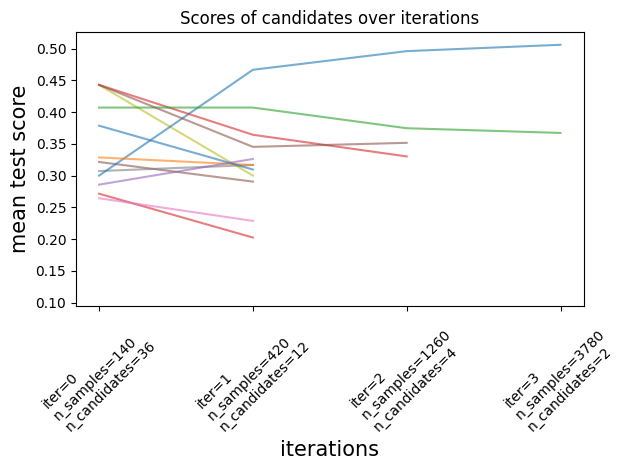

In [28]:
def plot_halving_grid_result(grid_result):
    results = pd.DataFrame(grid_result.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={grid_result.n_resources_[i]}\nn_candidates={grid_result.n_candidates_[i]}"
        for i in range(grid_result.n_iterations_)
    ]

    ax.set_xticks(range(grid_result.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("mean test score", fontsize=15)
    ax.set_xlabel("iterations", fontsize=15)
    plt.tight_layout()
    plt.show()

plot_halving_grid_result(halving_grid_search_result)

## Поиск оптимальных парметров обучения с помощью GridSearchCV

In [29]:
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def one_class_away_accuracy_score(y_true, y_pred):
    real_classes = y_true
    predicted_classes = y_pred

    # Exact and 1-class-away accuracy
    diffs = abs(real_classes - predicted_classes)

    return len(diffs[diffs <= 1]) / len(diffs)

def macro_precision_score(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def micro_precision_score(y_true, y_pred):
    return precision_score(y_true, y_pred, average='micro')

def macro_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro')

def micro_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, average='micro')

def macro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def micro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

def full_grid_search():
    def create_model():
        return build_model(
            original_input_shape=X.shape[1],
            n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
            n_unique_directors=X['director'].nunique(),
            n_unique_production_companies=X['production_company'].nunique(),
            n_unique_production_countries=X['production_country'].nunique(),
            n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
            n_classes=cfg.num_classes,
        )

    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience)

    model = KerasClassifier(
        build_fn=create_model,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        epochs=cfg.num_epochs,
        class_weight=class_weights,
        callbacks=[
            early_stopping,
        ],
        validation_split=0.1,
    )

    # С учетом результатов HalvingSearchCV
    params = {
        'optimizer': ['adamw'],
        'batch_size': [16, 32],
        "optimizer__learning_rate": [1e-3, 1e-4]
    }
    grid = GridSearchCV(
        estimator=model, 
        param_grid=params,
        scoring={
            'accuracy': make_scorer(accuracy_score),
            'one_class_away': make_scorer(one_class_away_accuracy_score),
            'macro_precision': make_scorer(macro_precision_score),
            'micro_precision': make_scorer(micro_precision_score),
            'macro_recall': make_scorer(macro_recall_score),
            'micro_recall': make_scorer(micro_recall_score),
            'macro_f1': make_scorer(macro_f1_score),
            'micro_f1': make_scorer(micro_f1_score),
        },
        cv=5,
        n_jobs=10,
        refit='accuracy',
    )

    grid_result = grid.fit(X_train, y_train)

    return grid_result
    

In [ ]:
import dill

full_grid_search_result = full_grid_search() # 3 min

with open(f'{cfg.checkpoint_path}full_grid.pkl', 'wb') as f:
    dill.dump(full_grid_search_result, f, protocol=5)

In [31]:
import dill

with open(f'{cfg.checkpoint_path}full_grid.pkl', 'rb') as f:
    full_grid_search_result = dill.load(f)

In [32]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_accuracy')[['params', 'mean_test_accuracy', 'rank_test_accuracy']])

,params,mean_test_accuracy,rank_test_accuracy
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.515831,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.503694,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.444327,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.299472,4


In [33]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_one_class_away')[['params', 'mean_test_one_class_away', 'rank_test_one_class_away']])

,params,mean_test_one_class_away,rank_test_one_class_away
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.931662,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.928760,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.782058,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.643536,4


In [34]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_macro_precision')[['params', 'mean_test_macro_precision', 'rank_test_macro_precision']])

,params,mean_test_macro_precision,rank_test_macro_precision
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.579358,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.577226,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.444039,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.309613,4


In [35]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_micro_precision')[['params', 'mean_test_micro_precision', 'rank_test_micro_precision']])

,params,mean_test_micro_precision,rank_test_micro_precision
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.515831,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.503694,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.444327,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.299472,4


In [36]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_macro_recall')[['params', 'mean_test_macro_recall', 'rank_test_macro_recall']])

,params,mean_test_macro_recall,rank_test_macro_recall
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.514189,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.501674,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.440425,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.296639,4


In [37]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_micro_recall')[['params', 'mean_test_micro_recall', 'rank_test_micro_recall']])

,params,mean_test_micro_recall,rank_test_micro_recall
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.515831,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.503694,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.444327,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.299472,4


In [38]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_macro_f1')[['params', 'mean_test_macro_f1', 'rank_test_macro_f1']])

,params,mean_test_macro_f1,rank_test_macro_f1
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.521913,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.508304,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.403417,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.232340,4


In [39]:
results = pd.DataFrame(full_grid_search_result.cv_results_)
with pd.option_context('display.max_colwidth', None):
    display(results.sort_values('rank_test_micro_f1')[['params', 'mean_test_micro_f1', 'rank_test_micro_f1']])

,params,mean_test_micro_f1,rank_test_micro_f1
2,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.515831,1
0,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.001}",0.503694,2
1,"{'batch_size': 16, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.444327,3
3,"{'batch_size': 32, 'optimizer': 'adamw', 'optimizer__learning_rate': 0.0001}",0.299472,4


## Обучение модели

In [40]:
from keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing import image

class TabularGenerator(Sequence):
    def __init__(
        self,
        tabular,
        labels,
        class_weights,
        batch_size = 32,
        shuffle = False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.tabular = tabular
        self.labels = labels
        self.class_weights = class_weights
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.labels) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        X = np.empty((self.batch_size, self.tabular.shape[1]), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int64)

        for i, idx in enumerate(indexes):
            X[i,] = self.tabular[idx]
            y[i] = self.labels[idx]

        return X, y

In [41]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
from pathlib import Path

def train_model(
    train_generator, 
    val_generator,
    class_weights,
    checkpoint_path,
):
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
    # Настраиваем callback для TensorBoardd
    tensorboard = TensorBoard(log_dir="./logs")

    # Обучение модели
    full_history = m.fit(
        x=train_generator,
        epochs=cfg.num_epochs,
        validation_data=val_generator,
        class_weight=class_weights,
        verbose=1,
        callbacks=[
            checkpoint,
            early_stopping,
            tensorboard,
        ],
    )
    best_model = load_model(checkpoint_path)

    p = Path(checkpoint_path)
    with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
        dill.dump(full_history, f, protocol=5)

    return best_model, full_history

In [ ]:
from keras.optimizers import AdamW, Adam
from pathlib import Path

m = build_model(
    original_input_shape=X.shape[1],
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
)
optimizer = AdamW(
    learning_rate=cfg.learning_rate,
)
m.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

train_generator = TabularGenerator(
    tabular=X_train.values,
    labels=y_train,
    batch_size=cfg.batch_size,
    class_weights=class_weights,
    shuffle=True,
)
val_generator = TabularGenerator(
    tabular=X_val.values,
    labels=y_val,
    batch_size=cfg.batch_size,
    class_weights=class_weights,
)

checkpoint_path = f'{cfg.checkpoint_path}best_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train_model(train_generator, val_generator, class_weights, checkpoint_path)

## Исследование модели

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Exact match accuracy: 0.5520833333333334
One class away accuracy: 0.9427083333333334
Precision per class: [0.55555556 0.375      0.44444444 0.52777778 0.90909091]
Recall per class: [0.625      0.23684211 0.60869565 0.54285714 0.73170732]
F1 score per class [0.58823529 0.29032258 0.51376147 0.53521127 0.81081081]
Macro Precision: 0.5623737373737374
Macro Recall: 0.5490204434734769
Macro F1: 0.5476682842138323
Micro Precision: 0.5520833333333334
Micro Recall: 0.5520833333333334
Micro F1: 0.5520833333333334


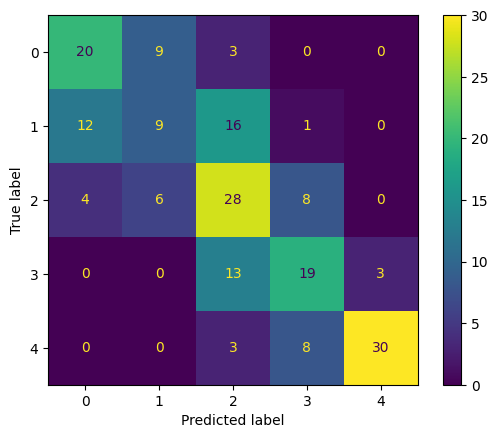

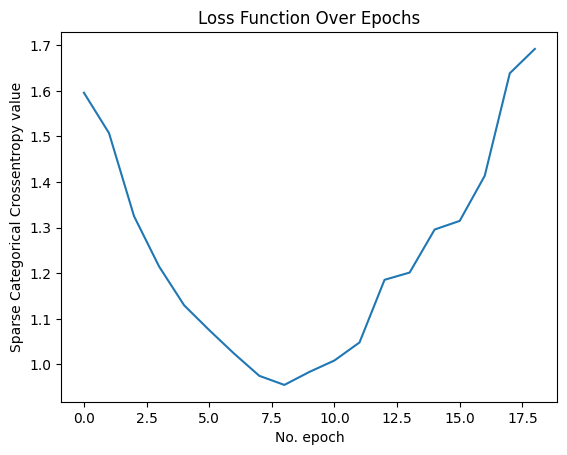

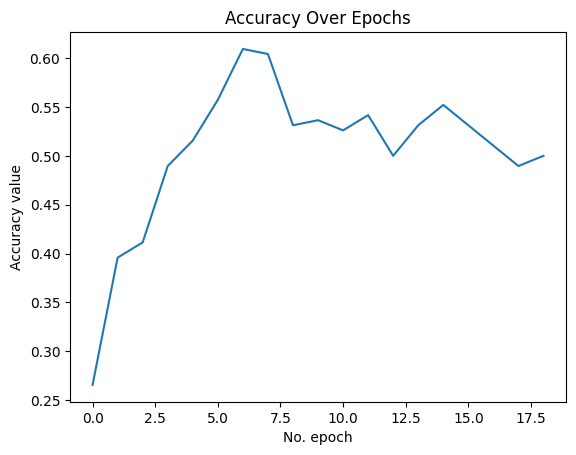

In [43]:
best_model = load_model(checkpoint_path)
with open(f'{cfg.checkpoint_path}/best_model_history.pkl', 'rb') as f:
    full_history = dill.load(f)


test_generator = TabularGenerator(
    tabular=X_test.values,
    labels=y_test,
    batch_size=cfg.batch_size,
    class_weights=class_weights,
)

# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, 'tabular', history=full_history)

In [79]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

## Permutation Feature Importance

Метод перестановочной важности признаков (permutation feature importance) представляет собой способ расчёта степени влияния каждого признака на прогнозы модели.
Достоинством метода является то, что он применим
* для любой модели (white-box, black-box models);
* для любой задачи (классификация, регрессия и др.);
* для любой функции потерь.

Таким образом, перестановочная важность признака показывает, во сколько/на сколько среднее качество прогнозов изменится, если модель не сможет использовать информацию, хранящуюся в этом признаке, при построении прогнозов.

[Источник](https://deepmachinelearning.ru/docs/Machine-learning/Complex-models-interpretation/Permutation-feature-importance)

In [44]:
def permutation_feature_importance(model, X_test, y_test, num_iter=10):
    baseline = model.evaluate(X_test, y_test)[1]

    onehot_columns = ['genre', 'release_month', 'mpaa']

    importance = {}

    for series_name, series in X_test.items():
        if (any(series_name.startswith(c) for c in onehot_columns)):
            continue
        importance[series_name] = []
        for _ in range(num_iter):
            X_permuted = X_test.copy()
            X_permuted[series_name] = np.random.permutation(series)
            score = model.evaluate(X_permuted, y_test)[1]
            importance[series_name].append(score / baseline)
            
    for c in onehot_columns:
        columns_to_shuffle = []
        for series_name, series in X_test.items():
            if (series_name.startswith(c)):
                columns_to_shuffle.append(series_name)

        importance[c] = []

        for _ in range(num_iter):
            X_permuted = X_test.copy()
            X_permuted[columns_to_shuffle] = np.random.permutation(X_permuted[columns_to_shuffle])
            score = model.evaluate(X_permuted, y_test)[1]
            importance[c].append(score / baseline)
        
    for k, v in importance.items():
        importance[k] = np.array(v)

    return importance

In [ ]:
importance = permutation_feature_importance(best_model, X_test, y_test, num_iter=100)

Построение графика для "важности" признака.

Видно, что наиболее важными признаками являются бюджет, актеры, продюсерская компания и режиссер. Самыми не важными - язык оригинала и дистрибьютор.
На основе этого приянто решение по исключению этих признаков из датасета.

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importance(importance):
    data = {
        k: [np.percentile(v, 5), np.mean(v), np.percentile(v, 95)] for k, v in importance.items()
    }

    # Создание списка названий признаков и списков с минимальными и максимальными значениями важности
    features = list(data.keys())
    features.sort(key=lambda k: data[k][1], reverse=True)
    min_values = [data[feature][0] for feature in features]
    mean_values = [data[feature][1] for feature in features]
    max_values = [data[feature][2] for feature in features]

    # Создание графика
    fig, ax = plt.subplots()

    # Построение полосок для каждого признака
    for i, feature in enumerate(features):
        ax.plot([min_values[i], max_values[i]], [i, i], color='black', linewidth=3)
        ax.plot(mean_values[i], i, 'ko')

    # Настройка осей и заголовков
    ax.set_ylim(-1, len(features))  # Установка границ по оси Y
    ax.set_yticks(range(len(features)))  # Установка меток на оси Y
    ax.set_yticklabels(features)  # Назначение названий признаков на оси Y
    ax.set_xlabel("Важность признака")  # Заголовок оси X

    # Отображение графика
    plt.show()

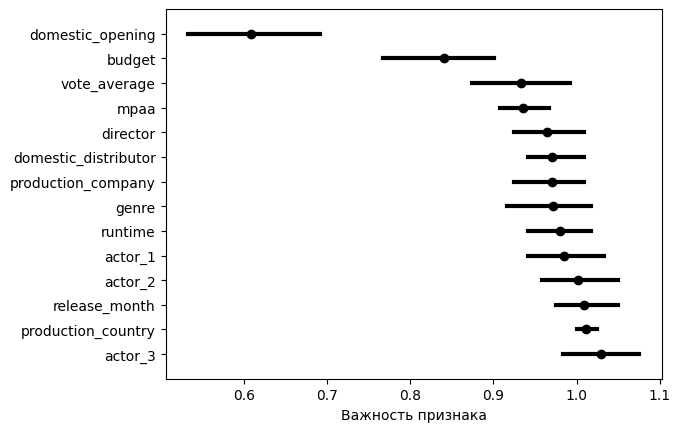

In [49]:
plot_importance(importance)